### Let's connect two motions

In [1]:
import time,pickle,mujoco,os
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,r2quat,MultiSliderClass,animiate_motion_with_slider,\
    pr2t,feet_anchoring,kernel_se,blend_tween_trajectories,get_gp_mean_function,\
    animate_motion_with_media
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.6]


### Parse `scene_common_rig_v2.xml`

In [2]:
xml_path = '../asset/common_rig/scene_common_rig_v2.xml'
env = MuJoCoParserClass(name='Common Rig',rel_xml_path=xml_path,VERBOSE=False)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs: env.model.geom(geom_idx).rgba = [0.9,0.9,0.9,0.5]
# Set which joints to control
rev_joint_names = env.ctrl_names 
print ("Done.")

Done.


### Initialize tick slider

In [3]:
# Open this once, and let's not close this. There's some problem with closing tkinter obj.
tick_slider = MultiSliderClass(
    n_slider=1,title='Tick slider',window_width=500,window_height=100,
    x_offset=950,y_offset=900,slider_width=350,label_texts=['Tick'],
    slider_mins=[0],slider_maxs=[100-1],slider_vals=[0],resolution=0.5,
    ADD_PLAYBACK=True,VERBOSE= False)
print ("[%s] Ready."%(tick_slider.title))

[Tick slider] Ready.


### Load two motions to `tween` and run `feet-anchoring`
VAAI_DIRECT_09_02_a_M1의 130 프레임에서 VAAI_DIRECT_03_01_a_M1의 93프레임으로 inbetweening 할 수 있을까요?
아래의 사항을 확인하고 싶습니다.
발 미끌림
서 있는 모션 사이에서 무게 중심이 움직일 경우 자연스러운 모션 생성
팔 동작 간의 모션 transition은 지금도 어느정도 자연스러워서 무게 중심 이동과 같은 사항들을 보고 싶습니다.
또한 팔 동작이 복잡한 쌍에 대해서도 한 번 확인하기 위해서는
VAAI_DIRECT_20_01_a_M1의 79 프레임에서 VAAI_DIRECT_10_01_c_M1의 37프레임으로 inbetweening 부탁드립니다.

In [4]:
# Important motion and tweening hyperparameters
HZ = 30 # basic motion frequency
intv_tween = 1.0 # time interval for tweening
intv_fade  = 0.3 # time interval for fading
print ("Tweening: HZ:[%d] intv_tween:[%.2f]sec intv_fade:[%.2f]sec"%
       (HZ,intv_tween,intv_fade))

Tweening: HZ:[30] intv_tween:[1.00]sec intv_fade:[0.30]sec


In [5]:
# pkl_path_1 = '../data/VAAI_DIRECT_09_02_a_M1.pkl'
# pkl_path_2 = '../data/VAAI_DIRECT_03_01_a_M1.pkl'
# tick_to_1 = 130//2
# tick_fr_2 = 93//2

pkl_path_1 = '../data/VAAI_DIRECT_20_01_a_M1.pkl'
pkl_path_2 = '../data/VAAI_DIRECT_10_01_c_M1.pkl'
tick_to_1 = 79//2
tick_fr_2 = 37//2

with open(pkl_path_1, 'rb') as f: data = pickle.load(f)
q_list_1         = data['qpos'][:,list(range(0,4))+list(range(5,12))+list(range(13,37))] # [L x 35]
quat_root_list_1 = r2quat(data['root_rot']) # [L x 4]
p_root_list_1    = data['root_translation'] # [L x 3]
q_list_1         = q_list_1[:tick_to_1,:]
quat_root_list_1 = quat_root_list_1[:tick_to_1,:]
p_root_list_1    = p_root_list_1[:tick_to_1,:]
L_1              = q_list_1.shape[0]
with open(pkl_path_2, 'rb') as f: data = pickle.load(f)
q_list_2         = data['qpos'][:,list(range(0,4))+list(range(5,12))+list(range(13,37))] # [L x 35]
quat_root_list_2 = r2quat(data['root_rot']) # [L x 4]
p_root_list_2    = data['root_translation'] # [L x 3]
q_list_2         = q_list_2[tick_fr_2:,:]
quat_root_list_2 = quat_root_list_2[tick_fr_2:,:]
p_root_list_2    = p_root_list_2[tick_fr_2:,:]
L_2              = q_list_2.shape[0]
print ("L_1:[%d], L_2:[%d]"%(L_1,L_2))

pkl_path_feetanchor = '../data/%s@%d_to_%s@%d.pkl'%(
    os.path.splitext(os.path.basename(pkl_path_1))[0],tick_to_1,
    os.path.splitext(os.path.basename(pkl_path_2))[0],tick_fr_2)
# Make folder if not exist
folder_path = os.path.dirname(pkl_path_feetanchor)
if not os.path.exists(folder_path): os.makedirs(folder_path)
# Run feet anchoring 
if os.path.exists(pkl_path_feetanchor):
    print ("Loading [%s]"%(pkl_path_feetanchor))
    with open(pkl_path_feetanchor,'rb') as f: data = pickle.load(f)
    p_root_centered_list_1 = data['p_root_centered_list_1']
    q_feetanchor_list_1    = data['q_feetanchor_list_1']
    p_root_centered_list_2 = data['p_root_centered_list_2']
    q_feetanchor_list_2    = data['q_feetanchor_list_2']
else:
    print ("[%s] does not exist"%(pkl_path_feetanchor))
    print ("Start feet anchoring...")
    res_1 = feet_anchoring(env,q_list_1,quat_root_list_1,p_root_list_1,rev_joint_names,
                           p_cfoot_offset = np.array([0,0,0.02]),d_rf2lf_custom=0.3,
                           ik_th=1e-3,ik_iters=5000,ANIMATE_IK=False)
    print ("(1/2) Feet anchoring done (L_1:[%d])"%(res_1['L']))
    res_2 = feet_anchoring(env,q_list_2,quat_root_list_2,p_root_list_2,rev_joint_names,
                           p_cfoot_offset = np.array([0,0,0.02]),d_rf2lf_custom=0.3,
                           ik_th=1e-3,ik_iters=5000,ANIMATE_IK=False)
    print ("(2/2) Feet anchoring done (L_2:[%d])"%(res_2['L']))
    p_root_centered_list_1,q_feetanchor_list_1 = res_1['p_root_centered_list'],res_1['q_feetanchor_list']
    p_root_centered_list_2,q_feetanchor_list_2 = res_2['p_root_centered_list'],res_2['q_feetanchor_list']
    # Save pkl
    with open(pkl_path_feetanchor,'wb') as pkl_file:
        data_to_save = {
            'p_root_centered_list_1':p_root_centered_list_1,
            'q_feetanchor_list_1':q_feetanchor_list_1,
            'p_root_centered_list_2':p_root_centered_list_2,
            'q_feetanchor_list_2':q_feetanchor_list_2
        }
        pickle.dump(data_to_save, pkl_file)
        print ("[%s] saved"%(pkl_path_feetanchor))
print ("Done.")

L_1:[39], L_2:[224]
Loading [../data/VAAI_DIRECT_20_01_a_M1@39_to_VAAI_DIRECT_10_01_c_M1@18.pkl]
Done.


### Animate two motions to blend

In [6]:
# Animate original motion a
animate_motion_with_media(
    env,p_root_list_1,quat_root_list_1,q_list_1,rev_joint_names,HZ,
    viewer_distance=5.0)

In [7]:
# Animate feet-anchored motion a
animate_motion_with_media(
    env,p_root_centered_list_1,quat_root_list_1,q_feetanchor_list_1,rev_joint_names,HZ)

In [8]:
# Animate original motion b
animate_motion_with_media(
    env,p_root_list_2,quat_root_list_2,q_list_2,rev_joint_names,HZ,
    viewer_distance=5.0)

In [9]:
# Animate feet-anchored motion b
animate_motion_with_media(
    env,p_root_centered_list_2,quat_root_list_2,q_feetanchor_list_2,rev_joint_names,HZ)

### Let's `tween` two motions

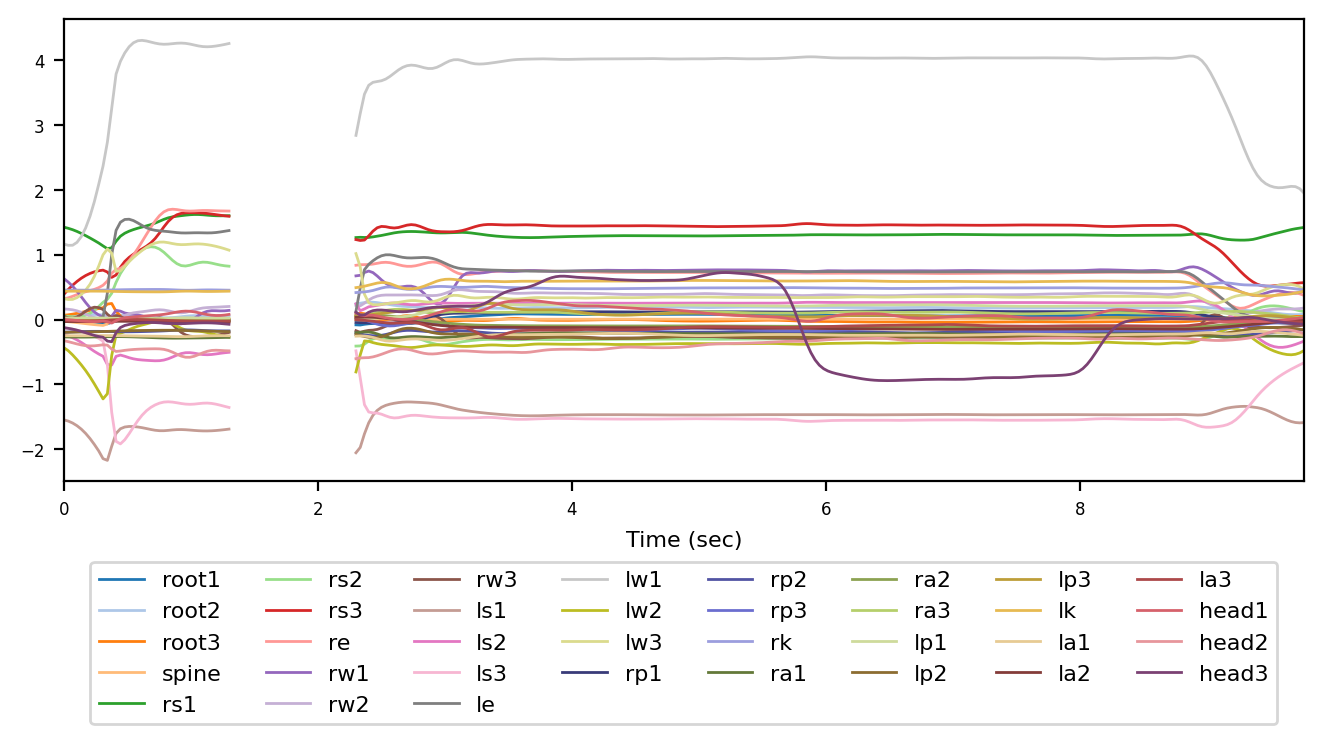

In [10]:
time_a_list = np.linspace(0,L_1/HZ,L_1)
time_b_list = np.linspace(0,L_2/HZ,L_2) + time_a_list[-1] + intv_tween
q_a_list = q_feetanchor_list_1.copy()
q_b_list = q_feetanchor_list_2.copy()
dim_q = q_a_list.shape[1] # dimension of joint position

# Plot two motions
plt.figure(figsize=(8,3))
colors = np.concatenate(
    [plt.cm.tab20(np.linspace(0,1,20))[:18],
     plt.cm.tab20b(np.linspace(0,1,20))[:18]])
for d_idx in range(dim_q):
    plt.plot(time_a_list,q_a_list[:,d_idx],'-',lw=1,color=colors[d_idx],label='%s'%(rev_joint_names[d_idx]))
    plt.plot(time_b_list,q_b_list[:,d_idx],'-',lw=1,color=colors[d_idx])
plt.xlim([0,time_b_list[-1]])
plt.xlabel('Time (sec)',fontsize=8)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15),ncol=8,fontsize=8)
plt.show()

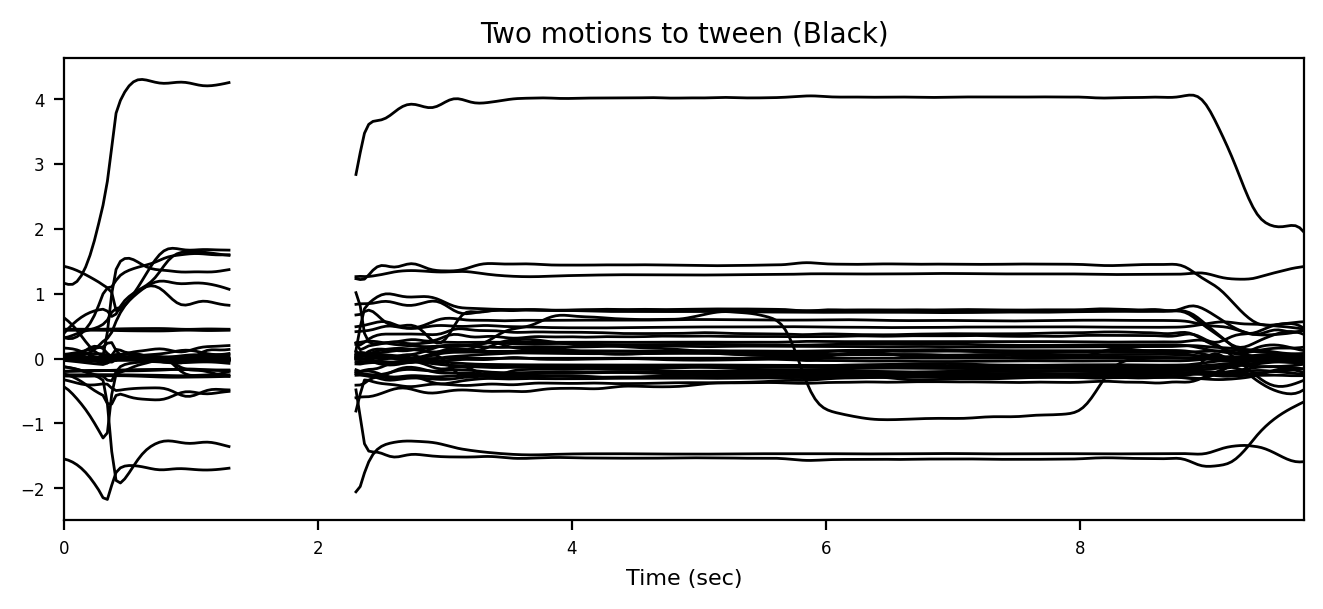

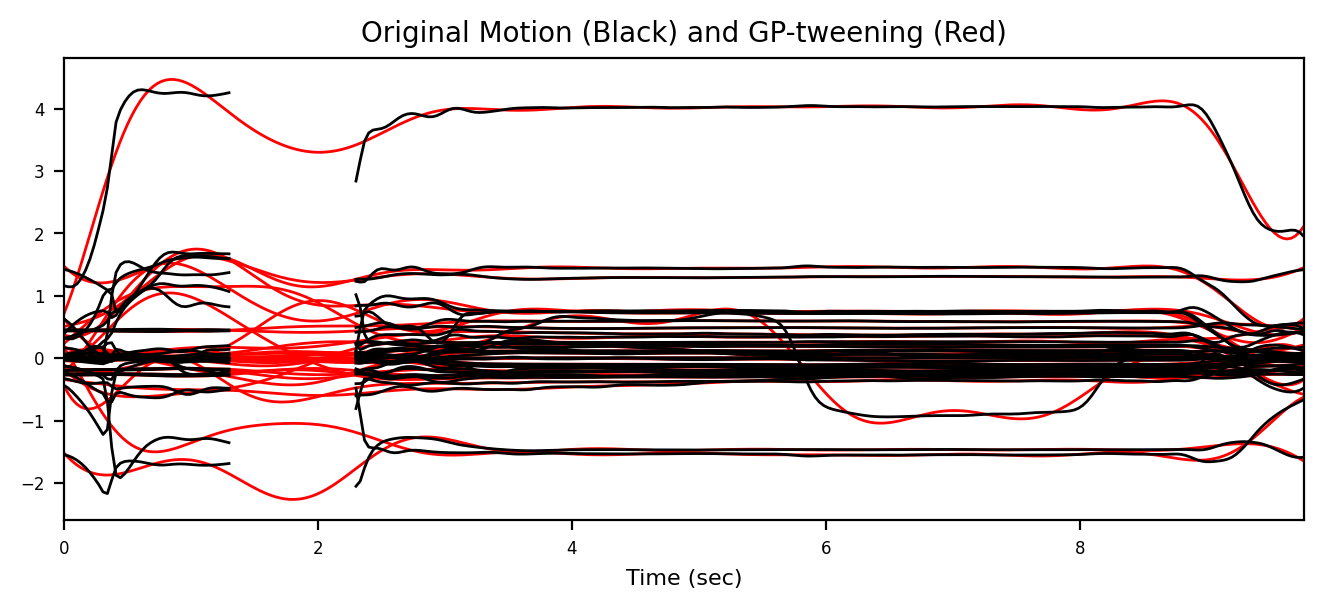

In [11]:
# First, run GPR
time_ab_list = np.concatenate((time_a_list,time_b_list))
q_ab_list = np.vstack((q_a_list,q_b_list))
time_tween_list = np.linspace(0,time_b_list[-1],int(time_b_list[-1]*HZ))
q_tween_gp_list = get_gp_mean_function(
    time_in_list=time_ab_list,x_in_list=q_ab_list,
    time_out_list=time_tween_list,hyp={'g':1.0,'l':1.0},sig2w=1e-4)

# First, plot two trajectories to tween
plt.figure(figsize=(8,3))
for d_idx in range(dim_q):
    plt.plot(time_a_list,q_a_list[:,d_idx],'-',lw=1,color='k',
             label='%s'%(rev_joint_names[d_idx]))
    plt.plot(time_b_list,q_b_list[:,d_idx],'-',lw=1,color='k')
plt.xlim([0,time_b_list[-1]])
plt.xlabel('Time (sec)',fontsize=8)
plt.title('Two motions to tween (Black)',fontsize=10)
plt.show()

# Then, plot two trajectories to tween + GP result
plt.figure(figsize=(8,3))
for d_idx in range(dim_q):
    plt.plot(time_tween_list,q_tween_gp_list[:,d_idx],'-',lw=1,color='r')
for d_idx in range(dim_q):
    plt.plot(time_a_list,q_a_list[:,d_idx],'-',lw=1,color='k',
             label='%s'%(rev_joint_names[d_idx]))
    plt.plot(time_b_list,q_b_list[:,d_idx],'-',lw=1,color='k')
plt.xlim([0,time_b_list[-1]])
plt.xlabel('Time (sec)',fontsize=8)
plt.title('Original Motion (Black) and GP-tweening (Red)',fontsize=10)
plt.show()

### Due to the discontinuity, let's run blending

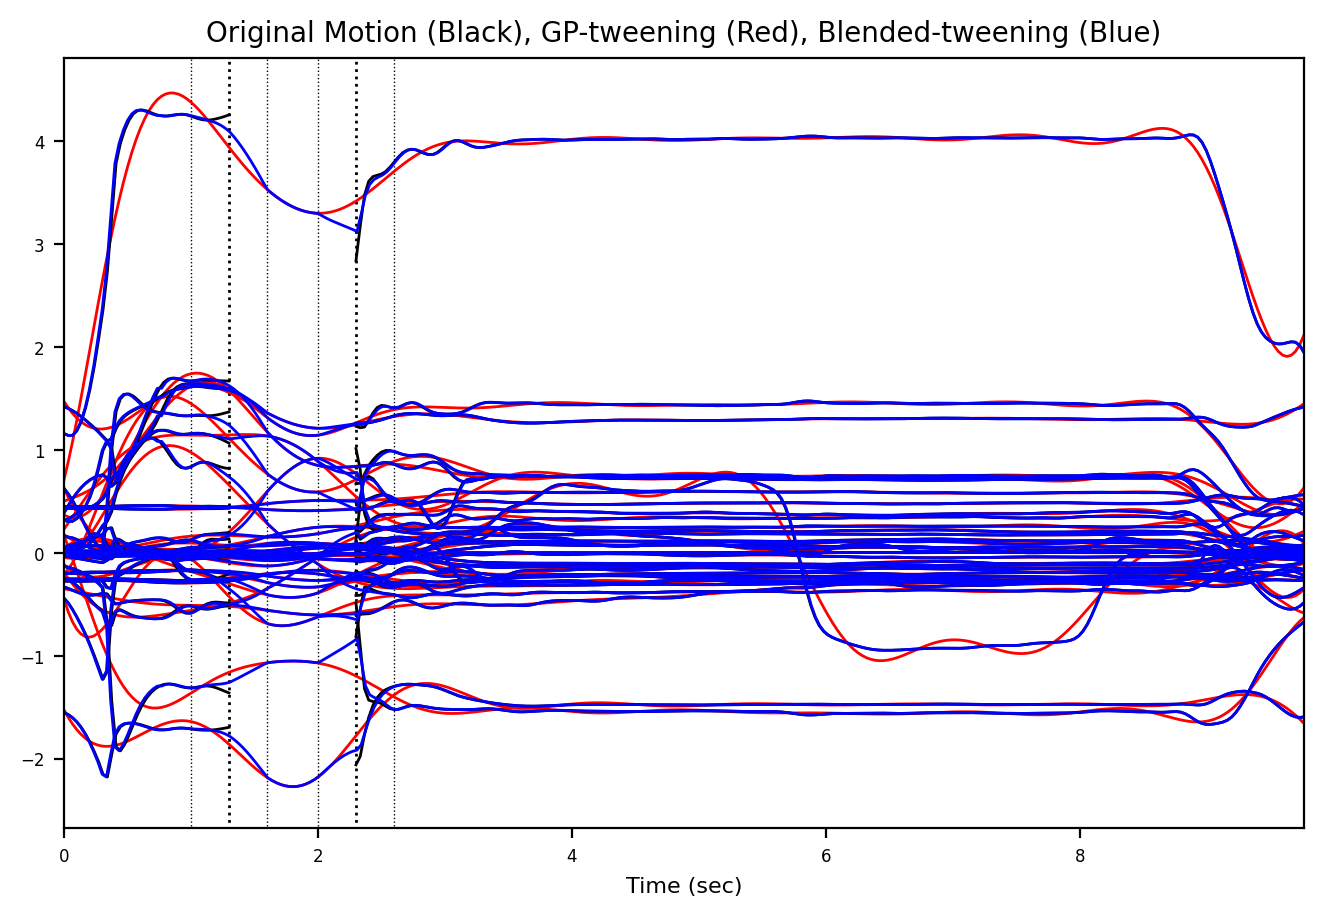

In [12]:
# Blending configuration
time_blend_list = time_tween_list.copy()
q_blend_list = blend_tween_trajectories(
    time_blend_list=time_blend_list,intv_fade=intv_fade,
    time_a_list=time_a_list,x_a_list=q_a_list,
    time_b_list=time_b_list,x_b_list=q_b_list,
    time_tween_list=time_tween_list,x_tween_list=q_tween_gp_list)
    
# Plot two trajectories to tween + GP result + Blended GP results
plt.figure(figsize=(8,5))
plt.plot([time_a_list[-1]-intv_fade,time_a_list[-1]-intv_fade],[-5,+5],
         ':',lw=1/2,color='k')
plt.plot([time_a_list[-1],time_a_list[-1]],[-5,+5],
         ':',lw=1,color='k')
plt.plot([time_a_list[-1]+intv_fade,time_a_list[-1]+intv_fade],[-5,+5],
         ':',lw=1/2,color='k')
plt.plot([time_b_list[0]-intv_fade,time_b_list[0]-intv_fade],[-5,+5],
         ':',lw=1/2,color='k')
plt.plot([time_b_list[0],time_b_list[0]],[-5,+5],
         ':',lw=1,color='k')
plt.plot([time_b_list[0]+intv_fade,time_b_list[0]+intv_fade],[-5,+5],
         ':',lw=1/2,color='k')
for d_idx in range(dim_q): plt.plot(time_tween_list,q_tween_gp_list[:,d_idx],'-',lw=1,color='r')
for d_idx in range(dim_q):
    plt.plot(time_a_list,q_a_list[:,d_idx],'-',lw=1,color='k',
             label='%s'%(rev_joint_names[d_idx]))
    plt.plot(time_b_list,q_b_list[:,d_idx],'-',lw=1,color='k')
for d_idx in range(dim_q): plt.plot(time_blend_list,q_blend_list[:,d_idx],'-',lw=1,color='b')    
plt.xlim([0,time_b_list[-1]])
plt.ylim([q_ab_list.min()-0.5,q_ab_list.max()+0.5])
#plt.ylim([1,2])
plt.xlabel('Time (sec)',fontsize=8)
plt.title('Original Motion (Black), GP-tweening (Red), Blended-tweening (Blue)',
          fontsize=10)
plt.show()

In [13]:
# Similarily, tween 'p_root_list' and 'quat_root_list'
p_root_a_list = p_root_centered_list_1
p_root_b_list = p_root_centered_list_2
quat_root_a_list = quat_root_list_1
quat_root_b_list = quat_root_list_2

# Root position
p_root_ab_list = np.vstack((p_root_a_list,p_root_b_list))
p_root_tween_gp_list = get_gp_mean_function(
    time_in_list=time_ab_list,x_in_list=p_root_ab_list,
    time_out_list=time_tween_list,hyp={'g':1.0,'l':1.0},sig2w=1e-8)
p_root_blend_list = blend_tween_trajectories(
    time_blend_list=time_blend_list,intv_fade=intv_fade,
    time_a_list=time_a_list,x_a_list=p_root_a_list,
    time_b_list=time_b_list,x_b_list=p_root_b_list,
    time_tween_list=time_tween_list,x_tween_list=p_root_tween_gp_list)

# Root quaternion
quat_root_ab_list = np.vstack((quat_root_a_list,quat_root_b_list))
quat_root_tween_gp_list = get_gp_mean_function(
    time_in_list=time_ab_list,x_in_list=quat_root_ab_list,
    time_out_list=time_tween_list,hyp={'g':1.0,'l':1.0},sig2w=1e-8)
quat_root_blend_list = blend_tween_trajectories(
    time_blend_list=time_blend_list,intv_fade=intv_fade,
    time_a_list=time_a_list,x_a_list=quat_root_a_list,
    time_b_list=time_b_list,x_b_list=quat_root_b_list,
    time_tween_list=time_tween_list,x_tween_list=quat_root_tween_gp_list)
quat_root_blend_list[:,0] = 1.0 
print ("Done.")

Done.


### Animate 

In [14]:
# Simple stacking of two motions
if False:
    animiate_motion_with_slider(
        env,tick_slider,
        np.vstack((q_a_list,q_b_list)),
        np.vstack((p_root_a_list,p_root_b_list)),
        np.vstack((quat_root_a_list,quat_root_b_list)),
        rev_joint_names,PLAY_AT_START=True)
print ("Done.")

Done.


In [15]:
# Our tweened motion
if False:
    animiate_motion_with_slider(
        env,tick_slider,
        q_blend_list,p_root_blend_list,quat_root_blend_list,
        rev_joint_names,PLAY_AT_START=True)
print ("Done.")

Done.


### Save video

In [16]:
# Motion
p_root_list    = p_root_blend_list
quat_root_list = quat_root_blend_list
q_list         = q_blend_list

# Animate
animate_motion_with_media(env,p_root_list,quat_root_list,q_list,rev_joint_names,HZ)

2023-10-10 09:58:12.744 python[54836:3334175] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (2.45 secs).


### Further `feet-anchor` the motion
q_blend_list, p_root_blend_list, quat_root_blend_list

In [17]:
pkl_path_post_feetanchor = '../data/%s@%d_to_%s@%d_post.pkl'%(
    os.path.splitext(os.path.basename(pkl_path_1))[0],tick_to_1,
    os.path.splitext(os.path.basename(pkl_path_2))[0],tick_fr_2)
# Run feet anchoring 
RE = False
if os.path.exists(pkl_path_post_feetanchor) and not RE:
    print ("Loading [%s]"%(pkl_path_post_feetanchor))
    with open(pkl_path_post_feetanchor,'rb') as f: data = pickle.load(f)
    p_root_blend_post_list    = data['p_root_blend_post_list']
    q_blend_post_list         = data['q_blend_post_list']
    quat_root_blend_post_list = data['quat_root_blend_post_list']
else:
    if RE:
        print ("Redo feet-anchoring.")
    else:
        print ("[%s] does not exist"%(pkl_path_post_feetanchor))
    print ("Start feet anchoring...")
    res_post = feet_anchoring(
        env,q_blend_list,quat_root_blend_list,p_root_blend_list,rev_joint_names,
        p_cfoot_offset = np.array([0,0,0.02]),d_rf2lf_custom=0.3,
        ik_th=1e-3,ik_iters=5000,ANIMATE_IK=False)
    print (" Feet anchoring done (L:[%d])"%(res_post['L']))
    p_root_blend_post_list    = res_post['p_root_centered_list']
    q_blend_post_list         = res_post['q_feetanchor_list']
    quat_root_blend_post_list = quat_root_blend_list.copy()
    # Save pkl
    with open(pkl_path_post_feetanchor,'wb') as pkl_file:
        data_to_save = {
            'p_root_blend_post_list':p_root_blend_post_list,
            'q_blend_post_list':q_blend_post_list,
            'quat_root_blend_post_list':quat_root_blend_post_list
        }
        pickle.dump(data_to_save, pkl_file)
        print ("[%s] saved"%(pkl_path_post_feetanchor))
# Little smoothing
q_blend_post_list = get_gp_mean_function(
    time_blend_list,q_blend_post_list,time_blend_list,hyp={'g': 1.0,'l':0.2},sig2w=1e-04)
p_root_blend_post_list = get_gp_mean_function(
    time_blend_list,p_root_blend_post_list,time_blend_list,hyp={'g': 1.0,'l':0.2},sig2w=1e-04)
quat_root_blend_post_list = get_gp_mean_function(
    time_blend_list,quat_root_blend_post_list,time_blend_list,hyp={'g': 1.0,'l':0.2},sig2w=1e-04)
print ("Done.")

Loading [../data/VAAI_DIRECT_20_01_a_M1@39_to_VAAI_DIRECT_10_01_c_M1@18_post.pkl]
Done.


In [20]:
# Our final feet-anchored motion
if True:
    animiate_motion_with_slider(
        env,tick_slider,
        q_blend_post_list,p_root_blend_post_list,quat_root_blend_post_list,
        rev_joint_names,PLAY_AT_START=True)
print ("Done.")

2023-10-10 09:58:36.583 python[54836:3334175] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (4.81 secs).


Pressed ESC
Quitting.
Done.


### Save video

In [19]:
# Motion
p_root_list    = p_root_blend_post_list
quat_root_list = quat_root_blend_post_list
q_list         = q_blend_post_list

# Animate
animate_motion_with_media(env,p_root_list,quat_root_list,q_list,rev_joint_names,HZ)

2023-10-10 09:58:23.540 python[54836:3334175] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (2.55 secs).
